In [1]:
import optiver2023
env = optiver2023.make_env()
iter_test = env.iter_test()

In [2]:
from sklearn.impute import SimpleImputer

In [3]:
counter = 0
for (test, revealed_targets, sample_prediction) in iter_test:
    if counter == 0:
        print(test.head(3))
        print(revealed_targets.head(3))
        print(sample_prediction.head(3))
    sample_prediction['target'] = 0
    env.predict(sample_prediction)
    counter += 1

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.
   stock_id  date_id  seconds_in_bucket  imbalance_size  \
0         0      478                  0      3753451.43   
1         1      478                  0       985977.11   
2         2      478                  0       599128.74   

   imbalance_buy_sell_flag  reference_price  matched_size  far_price  \
0                       -1         0.999875   11548975.43        NaN   
1                       -1         1.000245    3850033.97        NaN   
2                        1         1.000584    4359198.25        NaN   

   near_price  bid_price  bid_size  ask_price  ask_size  wap   row_id  
0         NaN   0.999875  22940.00   1.000050   9177.60  1.0  478_0_0  
1         NaN   0.999940   1967.90   1.000601  19692.00  1.0  478_0_1  
2         NaN   0.999918   4488.22   1.000636  34955.12  1.0  478_0_2  
   stock_id  date_id  seconds_in_bucket  revealed_target  rev

#### TOC
1. Anomalies in Data, and cleaning action & explaination. 15 pts
2. Pairwise Corralation Table and explaition. 10 pts
3. Average records stockID vs Day, 25 pts
    - a. autocorrelation, 10 pts
    - b. measure the distance, 5 pts
    - c. clustering algorithm, 10 pts
4. Closing trajectory of stocks on each day highly correlated, 25 pts
   - a. Make three plots, 10 pts
   - b. permutation test to determine the statistical confidence, 15 pts
      p-value
5. Best prediction model, any approaches, 25 pts
6. submit model on Kaggle, 0 pts

#### Start
- Copy this notebook.
  In Google Colab use `File -> Save a Copy in Drive`.
- Use the "Text" blocks to provide explanations wherever you find them necessary.
- Highlight your answers inside these text fields to ensure that we don't miss it
while grading your HW.

#### Setup

- Code to download the data directly from the colab notebook.
- If you find it easier to download the data from the kaggle website (and
uploading it to your drive), you can skip this section.

In [4]:
!ls '/kaggle/input/optiver-trading-at-the-close'

example_test_files  optiver2023  public_timeseries_testing_util.py  train.csv


#### Q1: Anomalies and Cleaning, 15 pts

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

col_names = [
  "stock_id",
  "date_id",
  "seconds_in_bucket",
  "imbalance_size",
  "imbalance_buy_sell_flag",
  "reference_price",
  "matched_size",
  "far_price",
  "near_price",
  "bid_price",
  "bid_size",
  "ask_price",
  "ask_size",
  "wap",
  "target",
  "time_id",
  "row_id"
]
dtypes = {
  "stock_id": np.int,
  "date_id":np.int,
  "seconds_in_bucket":np.int,
  "imbalance_size":np.float64,
  "imbalance_buy_sell_flag":np.int,
  "reference_price":np.float64,
  "matched_size":np.float64,
  "far_price":np.float64,
  "near_price":np.float64,
  "bid_price":np.float64,
  "bid_size":np.float64,
  "ask_price":np.float64,
  "ask_size":np.float64,
  "wap":np.float64,
  "target":np.float64,
  "time_id":np.int,
  "row_id": "string",
}
csv = pd.read_csv("/kaggle/input/optiver-trading-at-the-close/train.csv")

/tmp/ipykernel_20/1025626740.py:26: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  "stock_id": np.int,
/tmp/ipykernel_20/1025626740.py:27: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details a

In [6]:
csv.head(1)

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.5,1.000026,8493.03,1.0,-3.029704,0,0_0_0


In [7]:
csv.isnull().sum()

stock_id                         0
date_id                          0
seconds_in_bucket                0
imbalance_size                 220
imbalance_buy_sell_flag          0
reference_price                220
matched_size                   220
far_price                  2894342
near_price                 2857180
bid_price                      220
bid_size                         0
ask_price                      220
ask_size                         0
wap                            220
target                          88
time_id                          0
row_id                           0
dtype: int64

There are considerable null values in two columns: far_price and near_price (more than 50%). We will remove these two columns as including them in the predictions will likely hamper our error values.

In [8]:
temp_csv = csv[csv['far_price'].isnull()]

In [9]:
temp_csv.head(1)

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.5,1.000026,8493.03,1.0,-3.029704,0,0_0_0


In [10]:
csv.drop(labels=['far_price', 'near_price'], inplace=True, axis=1)

In [11]:
csv.isnull().sum()

stock_id                     0
date_id                      0
seconds_in_bucket            0
imbalance_size             220
imbalance_buy_sell_flag      0
reference_price            220
matched_size               220
bid_price                  220
bid_size                     0
ask_price                  220
ask_size                     0
wap                        220
target                      88
time_id                      0
row_id                       0
dtype: int64

In [12]:
numerical_columns = csv.select_dtypes(include=['number']).columns
categorical_columns = csv.select_dtypes(exclude=['number']).columns

numerical_imputer = SimpleImputer(strategy='median')
categorical_imputer = SimpleImputer(strategy='most_frequent')

csv[numerical_columns] = numerical_imputer.fit_transform(csv[numerical_columns])
csv[categorical_columns] = categorical_imputer.fit_transform(csv[categorical_columns])

For all the remaining NaN values, we will impute categorical columns with the mode and numerical columns with the median.

In [13]:
csv.isnull().sum()

stock_id                   0
date_id                    0
seconds_in_bucket          0
imbalance_size             0
imbalance_buy_sell_flag    0
reference_price            0
matched_size               0
bid_price                  0
bid_size                   0
ask_price                  0
ask_size                   0
wap                        0
target                     0
time_id                    0
row_id                     0
dtype: int64

Thus, all null values have been removed.

#### Q2: Pairwise Corralation Table and Explanation. 10 pts

In [14]:
correlation_matrix = csv.corr(method='pearson')

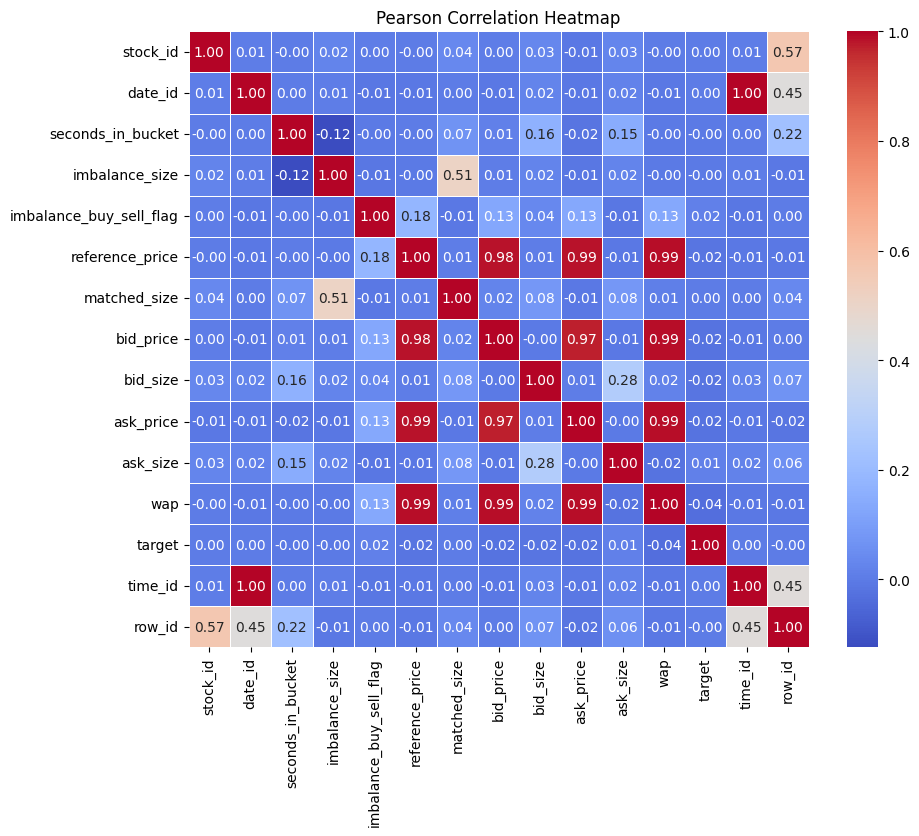

In [15]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Pearson Correlation Heatmap')
plt.show()

#### Q3: Average records stockID vs Day, 25 pts
distance function between entries
- a. autocorrelation, 10 pts
- b. measure the distance, 5 pts
- c. clustering algorithm, 10 pts

#### Q4: Closing trajectory of stocks on each day highly correlated, 25 pts
- a. Make three plots, 10 pts
- b. permutation test for statistical confidence, p-value, 15 pts

#### Q5: Best prediction model, any approaches, 25 pts

#### Q6: submit model on Kaggle, 0 pts
Public Score: \
Private Score: \
Kaggle profile link: \
Screenshot(s):
